# Shows results for example image of wheat plot

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

import import_ipynb
import wheat_dataset
from wheat_dataset import WheatDataset

from utils_dataset import get_transform_albumentation, get_transform_imgaug_img, get_transform_torch_img
from detection_transforms import Compose, PILToTensor, ConvertImageDtype, RandomHorizontalFlip
from detection_utils import collate_fn

import torch
import torchvision
from torchvision import transforms as T
from torchvision.utils import draw_segmentation_masks
from torchvision.utils import draw_bounding_boxes
import torchvision.ops as ops

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import numpy as np
import math
import copy
import cv2
import os
import time

# Functions

In [100]:
# prediction of model   ->    returns dictionary
def predict_image_window(model, image_window, score_threshold):
    # prediction
    image_window = Image.fromarray(image_window)
    image_window = get_transform_torch_img(image_window).cuda() / 255
    prediction = model([image_window])

    # save as tensor
    prediction[0]["boxes"] = torch.Tensor(prediction[0]["boxes"].cpu().detach().numpy())
    prediction[0]["scores"] = torch.Tensor(prediction[0]["scores"].cpu().detach().numpy())
    prediction[0]["labels"] = torch.Tensor(prediction[0]["labels"].cpu().detach().numpy())
    prediction[0]["masks"] = torch.Tensor(prediction[0]["masks"].cpu().detach().numpy())

    # remove predictions with small probability (score_threshold)
    prediction[0]["boxes"] = prediction[0]["boxes"][prediction[0]["scores"] > score_threshold]
    prediction[0]["labels"] = prediction[0]["labels"][:len(prediction[0]["boxes"])]
    prediction[0]["masks"] = prediction[0]["masks"][prediction[0]["scores"] > score_threshold]
    prediction[0]["scores"] = prediction[0]["scores"][:len(prediction[0]["boxes"])]

    return prediction[0]

In [101]:
# recalculate predicted boxes on 280x280 images onto position of original 521x1721 image    ->  returns predictions dictionary with updated boxes
def recalculate_bbs(predictions, num_columns):
    for i, pred in enumerate(predictions):
        scores = copy.deepcopy(pred["scores"])
        for j, box in enumerate(pred["boxes"]):
            x1, y1, x2, y2 = copy.deepcopy(box)
            # Calculate the row and column index of the current prediction
            row_idx = int(i % (len(predictions) // num_columns))
            col_idx = i // (len(predictions) // num_columns)
            # Calculate the new coordinates based on the row and column index
            new_x1 = x1 + col_idx * 120
            new_y1 = y1 + row_idx * 240
            new_x2 = x2 + col_idx * 120
            new_y2 = y2 + row_idx * 240
            pred["boxes"][j] = torch.stack([new_x1, new_y1, new_x2, new_y2])

    return predictions

In [102]:
# calculate center and pixel area of bounding boxes   ->  returns three lists: x, y and pixel area for bounding boxes
def get_box_center(boxes):
    x_center, y_center, pixel_areas = [], [], []
    for box in boxes:
        x1, y1, x2, y2 = box
        # calculate values
        x_mid = x1 + ((x2-x1) / 2)
        y_mid = y1 + ((y2-y1) / 2)
        pixel_area = (x2-x1) * (y2-y1)
        # append values to lists
        x_center.append(x_mid)
        y_center.append(y_mid)
        pixel_areas.append(pixel_area)
    return x_center, y_center, pixel_areas

In [103]:
def categorize_boxes(boxes):
    # x1, y1, x2, y2
    check_overlap = [(0,235,520,285), (0,475,520,525), (0,735,520,765),
                    (0,955,520,1005), (0,1195,520,1245), (0,1435,520,1485),
                    (120,0,400,1720)]

    # check_overlap = [(0,240,520,280), (0,480,520,520), (0,720,520,760),
    #                 (0,960,520,1000), (0,1200,520,1240), (0,1440,520,1480),
    #                 (240,0,280,1720)]
    # (120,0,400,1720)
    # (240,0,280,1720)

    overlap_boxes, normal_boxes = [], []
    for box in boxes:
        x1, y1, x2, y2 = box
        is_overlap = False

        for tup in check_overlap:
            if x1 >= tup[0] and x2 <= tup[2] and y1 >= tup[1] and y2 <= tup[3]:
                overlap_boxes.append(box)
                is_overlap = True
                break

        if not is_overlap:
            normal_boxes.append(box)

    overlap_boxes = torch.stack(overlap_boxes)
    normal_boxes = torch.stack(normal_boxes)
    return overlap_boxes, normal_boxes

In [104]:
def intersection_area(box1, box2):
    # Calculate the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Calculate the width and height of the intersection rectangle
    width = max(0, x2 - x1)
    height = max(0, y2 - y1)
    
    # Calculate the intersection area
    area = width * height
    
    return torch.as_tensor(area)

In [105]:
def area(box):
    x1, y1, x2, y2 = box
    width = x2 - x1
    height = y2 - y1

    return width * height

In [106]:
def intersection_filter(both_border_boxes):
    
    filtered_intersection_boxes_ids_deleted = set()
    filtered_intersection_boxes_ids = [i for i in range(both_border_boxes.shape[0])]

    copies = copy.deepcopy(both_border_boxes.tolist())

    my_count = 0

    for i in range(len(filtered_intersection_boxes_ids)-1, 0, -1):
        box1 = both_border_boxes[i]
        for j, box2 in enumerate(copies):
            if i == j:
                continue
        
            area_i = area(box1)
            intersection_ij = intersection_area(box1, box2)

            res = intersection_ij / area_i

            if res.item() > 0.5:
                filtered_intersection_boxes_ids_deleted.add(i)
                del copies[i]
                my_count += 1
                break

    filtered_intersection_boxes_ids = [i for i in range(len(filtered_intersection_boxes_ids)) if i not in filtered_intersection_boxes_ids_deleted]
    filtered_intersection_boxes = both_border_boxes[filtered_intersection_boxes_ids]

    both_border_boxes = filtered_intersection_boxes

    # print("Deleted Boxes:", my_count)

    return both_border_boxes

In [107]:
# removes overlapping boxes across all boxes and associates sub-image to box    ->     returns dict with boxes, scores and boxes with sub-image association
def remove_overlapping_boxes(predictions, iou_threshold):

    boxes = [torch.clone(prediction['boxes']) for prediction in predictions]
    scores = [torch.clone(prediction['scores']) for prediction in predictions]
    masks = [torch.clone(prediction['masks']) for prediction in predictions]

    # Concat all values
    boxes = torch.cat(boxes)
    scores = torch.cat(scores)
    masks = torch.cat(masks)

    # Apply NMS to the boxes
    keep = ops.nms(boxes, scores, iou_threshold)

    # Filter out boxes and scores that didn't meet the score threshold
    boxes = boxes[keep]
    scores = scores[keep]
    masks = masks[keep]

    overlap_boxes, normal_boxes = categorize_boxes(boxes)

    # print("Overlap Area Boxes:", len(overlap_boxes))
    filtered_boxes = intersection_filter(overlap_boxes)

    updated_boxes, all_intersection_unfiltered_boxes = [], []
    for box in normal_boxes:
        updated_boxes.append(box)
        all_intersection_unfiltered_boxes.append(box)
    for box in filtered_boxes:
        updated_boxes.append(box)
    for box in overlap_boxes:
        all_intersection_unfiltered_boxes.append(box)
    updated_boxes = torch.stack(updated_boxes)
    all_intersection_unfiltered_boxes = torch.stack(all_intersection_unfiltered_boxes)

    # Return the filtered boxes, scores, and masks as a dictionary
    predictions = {
        'scores': scores,
        'boxes': boxes,
        'masks': masks,
        'normal_boxes': normal_boxes,
        'overlap_boxes': overlap_boxes,
        'all_inter_unf_boxes': all_intersection_unfiltered_boxes,
        'filtered_boxes': filtered_boxes,
        'updated_boxes': updated_boxes
    }

    return predictions

In [108]:
# reconstructs mask for 520x1720 image and to filter for later purposes    ->     returns tensor of masks
def create_mask(predictions, num_columns):
    new_mask = []
    transform_pil = T.ToPILImage()
    transform_tensor = T.ToTensor()
    # iter over all 280x280 predictions
    for i, pred in enumerate(predictions):
        tmp = Image.new("L", (521, 1721))
        # iter over every mask for each prediction
        for k, mask in enumerate(pred["masks"]):
            mask = transform_pil(mask)
            index = i % int(len(predictions)/num_columns)
            # 1st row:      i < 7
            if i < len(predictions) / num_columns:
                tmp.paste(mask, (0, index*mask.size[1] - index*40))
            # 2nd row:      i >= 7 AND i < 14
            if (i >= len(predictions) / num_columns) and (i < len(predictions) / num_columns * 2):
                tmp.paste(mask, ((mask.size[1]-140) - 20, index*mask.size[1] - index*40))
            # 3rd row:      i >= 14
            if i >= len(predictions) / num_columns * 2:
                tmp.paste(mask, (mask.size[1] - 40, index*mask.size[1] - index*40))
            new_mask.append(transform_tensor(tmp))
    new_mask = torch.stack(new_mask).squeeze(1)
    return new_mask

In [109]:
# reconstructs mask for 520x1720 image and to filter for later purposes    ->     returns tensor of masks
def create_mask(predictions, num_columns):
    new_mask = []
    transform_pil = T.ToPILImage()
    transform_tensor = T.ToTensor()
    # iter over all 280x280 predictions
    for i, pred in enumerate(predictions):
        tmp = Image.new("L", (521, 1721))
        # iter over every mask for each prediction
        for k, mask in enumerate(pred["masks"]):
            mask = transform_pil(mask)
            index = i % int(len(predictions)/num_columns)
            # 1st row:      i < 7
            if i < len(predictions) / num_columns:
                tmp.paste(mask, (0, index*mask.size[1] - index*40))
            # 2nd row:      i >= 7 AND i < 14
            if (i >= len(predictions) / num_columns) and (i < len(predictions) / num_columns * 2):
                tmp.paste(mask, ((mask.size[1]-140) - 20, index*mask.size[1] - index*40))
            # 3rd row:      i >= 14
            if i >= len(predictions) / num_columns * 2:
                tmp.paste(mask, (mask.size[1] - 40, index*mask.size[1] - index*40))
            new_mask.append(transform_tensor(tmp))
    new_mask = torch.stack(new_mask).squeeze(1)
    return new_mask

In [110]:
# get counts of wheat heads for big image   ->     returns numpy array
def get_grid_counts(x_filtered, y_filtered, gridsize_heatmap, cells_w, cells_h):
    all_grids = []

    # iterate over all x,y coordiantes and count for each grid cell
    for i in range(len(x_filtered)):
        grid_counts = [[0 for j in range(cells_h)] for i in range(cells_w)]
        centers = zip(x_filtered, y_filtered)
        for x,y in centers:
            row_index = int(y // gridsize_heatmap)
            col_index = int(x // gridsize_heatmap)
            grid_counts[row_index][col_index] += 1
        all_grids.append(grid_counts)
    np_grids = [np.array(grid) for grid in all_grids]

    return np_grids[0].T

In [111]:
# get count and paths for all 510 images
def get_files(root_path):
    dir_path = r'/data/departments/schoen/roessle/HSWT_Aehrenzaehlen/images_full_plots/'
    all_paths = []
    count = 0
    # Iterate directory
    for path in os.listdir(dir_path):
        all_paths.append(root_path + path)
        if os.path.isfile(os.path.join(dir_path, path)):
            count += 1
    print('File count:', count)
    return(all_paths)

# Main Function and Plots

File count: 510
Selected number of images: 1
(1721, 521)


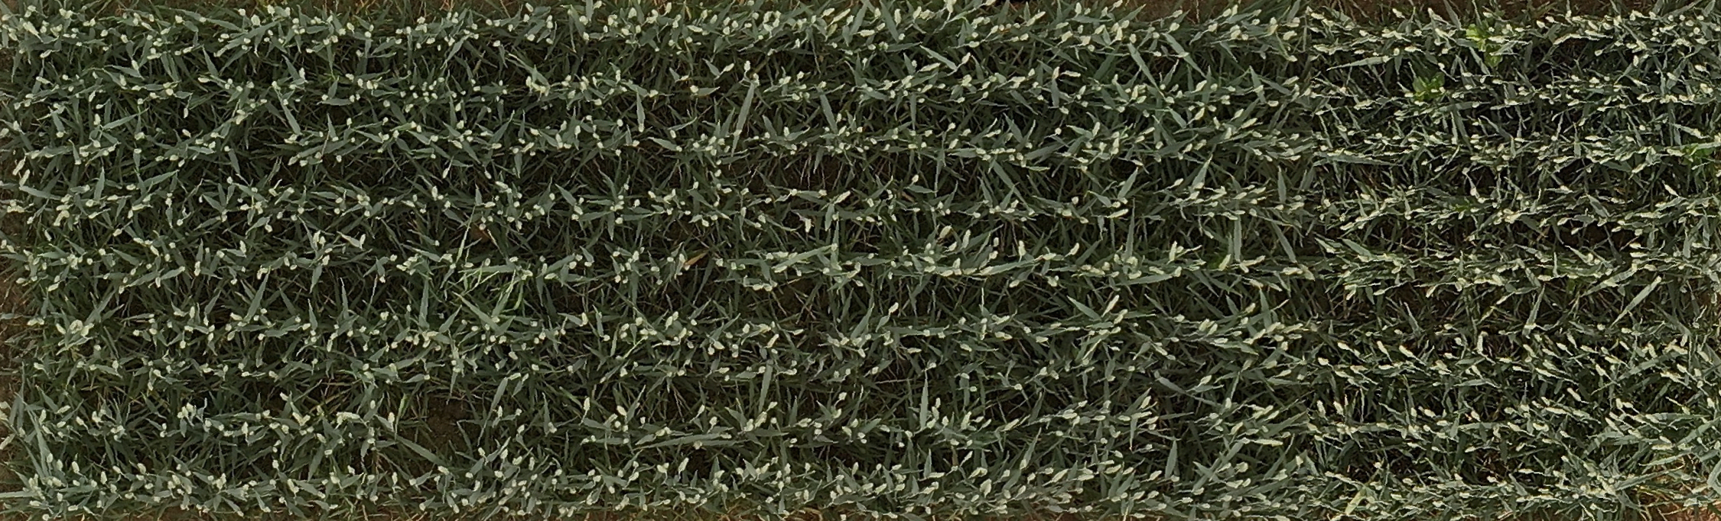

In [112]:
model_path = "/home/emj6571/model/model_5_epochs_2022-12-14_v2.pt"
model = torch.load(model_path)

root_path = "/data/departments/schoen/roessle/HSWT_Aehrenzaehlen/images_full_plots/"

all_paths = get_files(root_path)
images_list = []

indices = torch.randperm(len(all_paths)).tolist()
number_of_images = len(all_paths)

for path in all_paths:
    if path == '/data/departments/schoen/roessle/HSWT_Aehrenzaehlen/images_full_plots/DOP_AD22_HZ_D10_RGB_18mm_UTM32_____multi_band___parcel_10108_buff_0.0.tif':
        image = path

# preprocess images
# for index in indices[:number_of_images]:
#     image = all_paths[index]
im = Image.open(image)
im = im.rotate(85, expand=True)

# (left,top), (right,bottom)
im = im.crop((350, 325, 2600, 1025))
# im = im.crop((350, 400, 2600, 950))
im = im.resize(size=(1721, 521))
# part_im_left= im.crop((200, 40, 400, 240))
# part_im_right = im.crop((1320, 280, 1520, 480))

image = np.array(im)
image = image.transpose(1,0,2)
images_list.append(image)
        
print(f"Selected number of images: {len(images_list)}")
print(im.size)
im

In [113]:
score_threshold = 0.7
mask_threshold = 0.5
iou_threshold = 0.2

In [118]:
def main(model, image, score_threshold, iou_threshold, mask_threshold):
    COLORS = [(255,0,0), (0,255,0), (0,0,255)]
    counter = 0
    image_counter = 0

    # sliding window 
    images = []
    # tmp = image
    step_size_width = 120
    step_size_heigth = 240
    num_columns = math.floor(image.shape[1] / (280-120))
    (w_width, w_height) = (280, 280)
    for x in range(0, image.shape[1] - w_width , step_size_width):       # width
        for y in range(0, image.shape[0] - w_height, step_size_heigth):    # heigth
            image_window = image[y:y + w_height, x:x + w_width, :]
            images.append(image_window)
            # cv2.rectangle(tmp, (x, y), (x + w_width, y + w_height), COLORS[counter], 2)   # show sub-image crops
        counter += 1
    sub_image_count = len(images)

    # predictions for sliding window     
    predictions = []
    parcel_count = []
    for i, image in enumerate(images, start=1):
        prediction = predict_image_window(model, image, score_threshold)
        predictions.append(prediction)
        parcel_count.append(len(prediction["boxes"][prediction["scores"] > score_threshold]))

    print(f"Image Number: {image_counter}")

    mask = create_mask(predictions, num_columns)
    filtered_mask = mask.sum(dim=0) > mask_threshold

    predictions = recalculate_bbs(predictions, num_columns)

    sub_image_boxes = [pred["boxes"] for pred in predictions]

    predictions = remove_overlapping_boxes(predictions, iou_threshold)

    x_filtered, y_filtered, pixel_areas = get_box_center(predictions["updated_boxes"])
    image_counter += 1

    return predictions, x_filtered, y_filtered, pixel_areas, sub_image_boxes, filtered_mask

In [119]:
predictions, x_filtered, y_filtered, pixel_areas, sub_image_boxes, filtered_mask = main(model, 
                                                                                        image, 
                                                                                        score_threshold,
                                                                                        iou_threshold, 
                                                                                        mask_threshold)

Image Number: 0


# Plot of Image Predictions

In [126]:
# Plot image prediction for index idx
def image_plot(image, predictions, x_filtered, y_filtered, pixel_areas, sub_image_boxes, filtered_mask):
    image = image.transpose(1,0,2)

    transform = T.Compose([T.ToTensor(), T.ConvertImageDtype(torch.uint8)])
    torch_img = transform(image)

    torch_img_boxes = draw_bounding_boxes(torch_img.permute(0,2,1), predictions["updated_boxes"], colors=(255,0,0))
    torch_img_masks = draw_segmentation_masks(torch_img_boxes, filtered_mask, colors=(0,0,255), alpha=0.5).permute(2,1,0)
    
    n_wheatheads = len(predictions["updated_boxes"])

    # Plots normal image with boxes
    f0 = plt.figure(figsize=(30,16))
    plt.title(f"Image of filtered spikes - Wheat count: {n_wheatheads}", fontsize=20)
    implot1 = plt.imshow(torch_img_masks)
    plt.show(block=True)

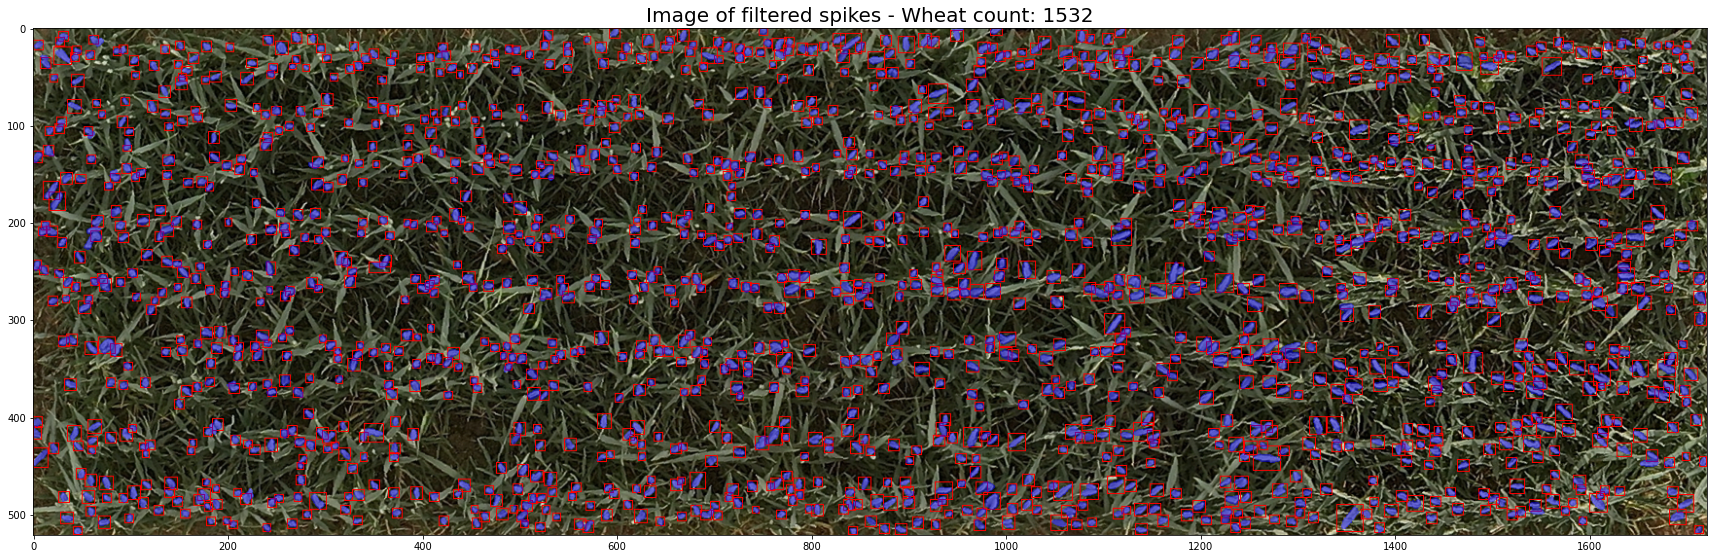

In [127]:
"""Single Plot; benötigt Masken, welche in dieser Datei wegen Speichergründen nicht abgespeichert werden"""
image_plot(image, predictions, x_filtered, y_filtered, pixel_areas, sub_image_boxes, filtered_mask)

In [128]:
gridsize_heatmap = 40
cells_w = int(1720 / gridsize_heatmap)
cells_h = int(520 / gridsize_heatmap)

In [129]:
np_grid = get_grid_counts(x_filtered, y_filtered, gridsize_heatmap, cells_w, cells_h)

# Plot of Heatmaps

In [130]:
# Plots count (and density) heatmap
def heatmaps(image, x_filtered, y_filtered, np_grid, gridsize_heatmap):
    row, column = np_grid.shape
    
    f1 = plt.figure(figsize=(30,16))
    f1.add_subplot(1,1,1)
    heatmap_big = plt.imshow(np_grid, cmap='YlOrRd')
    for i in range(row):
        for j in range(column):
            plt.text(j, i, np_grid[i][j], ha="center", va="center", color="black", fontsize=15)
    plt.title("Count heatmap for image of plot", fontsize=20)
    plt.yticks(ticks=np.arange(row), labels=["y{}".format(i+1) for i in range(row)])
    plt.xticks(ticks=np.arange(column), labels=["x{}".format(i+1) for i in range(column)])
    f1.colorbar(heatmap_big, shrink=0.5)
    plt.show(block=True)

    f2 = plt.figure(figsize=(30,16))
    f2.add_subplot(1,1,1)
    plt.title("Grid with wheat head center points for image of plot", fontsize=20)
    plt.plot(y_filtered, x_filtered, 'ro', markersize=3)
    implot3 = plt.imshow(image.transpose(1,0,2), extent=[0, 1721, 521, 0])
    for x in range(0, 1721, gridsize_heatmap):
        plt.plot([x, x], [0, 521], c='b', linewidth=1)
    for y in range(0, 521, gridsize_heatmap):
        plt.plot([0, 1721], [y, y], c='b', linewidth=1)

    plt.show(block=True)

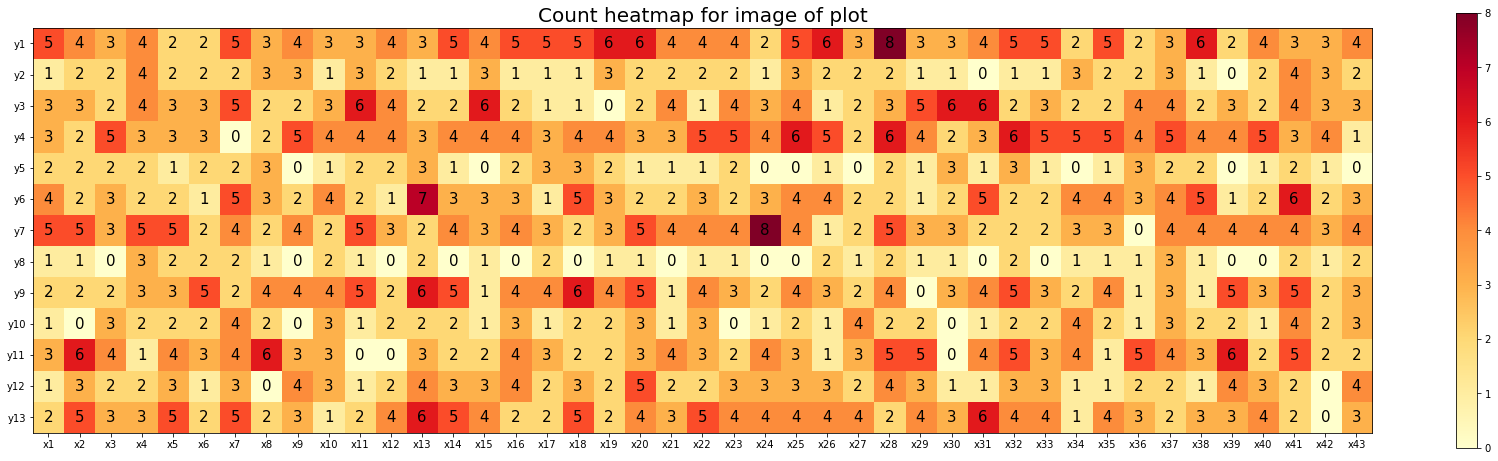

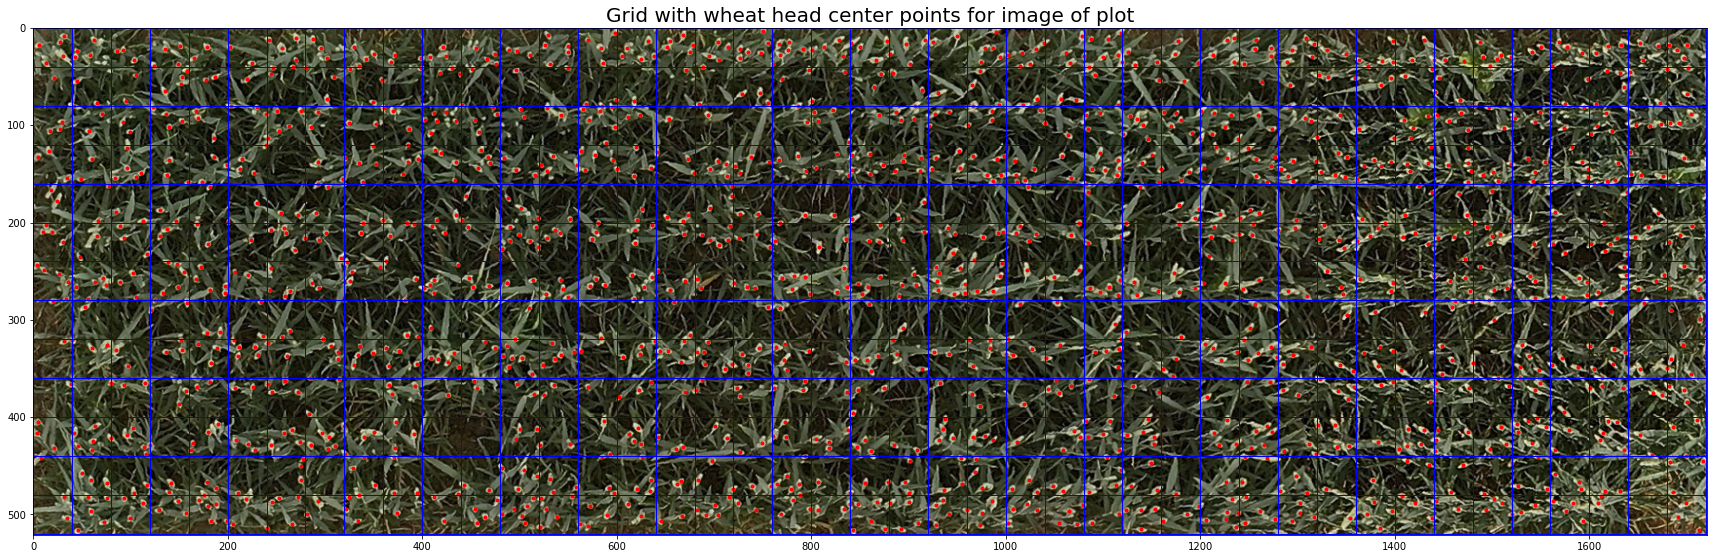

In [131]:
heatmaps(image, x_filtered, y_filtered, np_grid, gridsize_heatmap)

# Plot of gradient density map

In [132]:
# plots gradient density map
def plot_gradient_density(image, filtered_boxes, x_filtered, y_filtered, filtered_mask, pixel_areas):
    image = image.transpose(1,0,2)
    height, width, channels = image.shape

    WIDTH_PIXELS = math.floor(width*0.06)
    HEIGHT_PIXELS = math.floor(height*0.1)
    COLORS = ['ro', 'bo', 'mo']
    n_areas = 2
    scaling_factor = 1.44

    x, y, areas = density_division(y_filtered, x_filtered, width, height, WIDTH_PIXELS, HEIGHT_PIXELS, n_areas, pixel_areas, scaling_factor)

    red_c, blue_c, magenta_c = len(x[0]), len(x[1]), len(x[2]) 
    total_wheatheads = red_c + blue_c + magenta_c

    outer = Rectangle((1, 1), width-1, height-1, fill=False, color='r', linewidth=2)
    middle = Rectangle((WIDTH_PIXELS, HEIGHT_PIXELS), width-2*WIDTH_PIXELS, height-2*HEIGHT_PIXELS, fill=False, color='b', linewidth=2)
    inner = Rectangle((WIDTH_PIXELS*(n_areas+scaling_factor), HEIGHT_PIXELS*n_areas), width-n_areas*(n_areas+scaling_factor)*WIDTH_PIXELS, height-n_areas*n_areas*HEIGHT_PIXELS, fill=False, color='m', linewidth=2)

    outer_area = height*width - middle.get_window_extent().width*middle.get_window_extent().height
    middle_area = middle.get_window_extent().width*middle.get_window_extent().height - inner.get_window_extent().width*inner.get_window_extent().height
    inner_area = inner.get_window_extent().width*inner.get_window_extent().height

    # Plots divised image
    print()
    print(f"Division: Each sub-area is about 33% of the total area")
    f = plt.figure(figsize=(30,16))
    ax = f.add_subplot(1,1,1)
    plt.title(f"Density Division Image - Red: {len(x[0])}, Blue: {len(x[1])}, Magenta: {len(x[2])}", fontsize=20)
    for i in range(len(COLORS)):
        plt.plot(x[i], y[i], COLORS[i], markersize=4)
    implot2 = plt.imshow(image, extent=[0, width, height, 0])
    ax.add_patch(outer)
    ax.add_patch(middle)
    ax.add_patch(inner)
    plt.show(block=True)

    # Population Density for each region
    print(f"Magenta: {magenta_c} - {np.round(magenta_c/total_wheatheads*100, 3)}%")
    print(f"Blue: {blue_c} - {np.round(blue_c/total_wheatheads*100, 3)}%")
    print(f"Red: {red_c} - {np.round(red_c/total_wheatheads*100, 3)}%")
    print()
    print(f'Inner population density by count: {np.round(magenta_c/inner_area*100, 3)} wheat heads/pixel')
    print(f'Middle population density by count: {np.round(blue_c/middle_area*100, 3)} wheat heads/pixel')
    print(f'Outer population density by count: {np.round(red_c/outer_area*100, 3)} wheat heads/pixel')
    print()
    print(f'Inner population density by area: {np.round(float(areas[2])/inner_area*100, 3)}%')
    print(f'Middle population density by area: {np.round(float(areas[1])/middle_area*100, 3)}%')
    print(f'Outer population density by area: {np.round(float(areas[0])/outer_area*100, 3)}%')
    print()
    print(f"Total population density by count: {np.round((magenta_c+blue_c+red_c) / (inner_area + middle_area + outer_area) * 100, 3)} wheat heads/pixel")
    print(f"Total population density by area: {np.round((float(areas[2])+float(areas[1])+float(areas[0])) / (inner_area + middle_area + outer_area) * 100, 3)}%")

In [133]:
plot_gradient_density(image, filtered_boxes, x_filtered, y_filtered, filtered_mask, pixel_areas)

NameError: name 'filtered_boxes' is not defined